<a href="https://colab.research.google.com/github/AkhilaSan/Lever-Cue-Widefield-Calcium-Imaging-Anlaysis/blob/main/Neuroethology_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AUC DFF of calcium signals from pull_onset to last lever pull before pull_onset + 0.4 sec (movement_duration) for all brain regions and all animals for both day 1 and day 5.

Also included in the dataframe, mouse_id, trial number, reaction time, movement_duration length, tpull final (last pull duration for success value of the session), and day (5 or 1).

Make sure to add the braidyn-bc google folder shortcut to your drive. https://drive.google.com/drive/folders/1DtufNi90fhQp6kIcuS0MxtTz-Uk5LSS9?usp=drive_link


In [ ]:
!pip install -U git+https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git

  Cloning https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git to /tmp/pip-req-build-767tx7ho
  Running command git clone --filter=blob:none --quiet https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git /tmp/pip-req-build-767tx7ho
  Resolved https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git to commit 309c5fbdbc065cffdaf46e9160383545e5c8104f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.0/339.0 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 35.2 MB/s eta 0:00:00
  Created wheel for bdbc-nwb-explorer: filename=bdbc_nwb_explorer-0.3.10-py3-none-any.whl size=39598 sha256=bb40b6a582bc7457d8074205dd02d5bacd85a17df3137d0f5d37f4fa746840ed
  Stored in directory: /tmp/pip

In [ ]:
from time import time as now
from pathlib import Path

from google.colab import drive
import bdbc_nwb_explorer as nwbx

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# connect to your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Extracting all of the task day 5 and 1 file paths for all subjects

In [ ]:
dataroot = Path('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data')
task_day5_files = [f for f in dataroot.rglob('*.nwb') if '_task-day5.nwb' in f.name]
task_day1_files = [f for f in dataroot.rglob('*.nwb') if '_task-day1.nwb' in f.name]
print(task_day5_files)

[PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-54/VG1GC-54_2023-06-21_task-day5.nwb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-53/VG1GC-53_2023-06-21_task-day5.nwb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-51/VG1GC-51_2023-06-21_task-day5.nwb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-52/VG1GC-52_2023-06-21_task-day5.nwb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-60/VG1GC-60_2023-06-21_task-day5.nwb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-61/VG1GC-61_2023-06-21_task-day5.nwb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-66/VG1GC-66_2023-08-25_task-day5.nwb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-87/VG1GC-87_2023-10-30_task-day5.nwb'), PosixPath('/content/drive/MyDrive/Colab Notebooks/braidyn-bc/data/VG1GC-99/VG1GC-99_2024-01-30_task-day

In [ ]:
def find_threshold_crossings(data, thresholds):
    """
    Finds the time points where the data crosses specified thresholds.

    Args:
        data (pd.Series): Time series data.
        thresholds (list): A list of threshold values.

    Returns:
        dict: A dictionary where keys are thresholds and values are lists
              of time points where the data crosses that threshold.
    """
    crossings = {threshold: [] for threshold in thresholds}
    for i in range(1, len(data)):
        for threshold in thresholds:
            # Check for crossing from below
            if data.iloc[i-1] < threshold and data.iloc[i] >= threshold:
                crossings[threshold].append(data.index[i])
            # Check for crossing from above
            elif data.iloc[i-1] > threshold and data.iloc[i] <= threshold:
                crossings[threshold].append(data.index[i])
    return crossings

In [ ]:
from time import time as now
from pathlib import Path

from google.colab import drive
import bdbc_nwb_explorer as nwbx

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# connect to your Google Drive
drive.mount('/content/drive')

all_sessions_auc_dff = []

for file_path in task_day5_files:
    print(f"Processing {file_path.name}...", end=' ', flush=True)
    start = now()
    session = nwbx.read_nwb(file_path)
    stop = now()
    print(f"done (took {(stop - start) / 60:.1f} min)", flush=True)

    # Define your threshold
    thresholds = [3.0] # Changed to a single threshold of 3.0
    trials = session.trials.data
    pull_onset = trials['pull_onset'].values
    brain_regions = session.imaging.data.columns
    t_pull_final = trials['pull_duration_for_success'].values[-1]
    reaction_time = trials['reaction_time'].values
    stop_time = trials['stop_time'].values
    # Apply the function to the lever data
    lever_crossings = find_threshold_crossings(session.daq['lever'].data['lever'], thresholds)

    auc_dff_data = []
    for i, onset_time in enumerate(pull_onset):
        auc_dff_row = {}
        if not np.isnan(onset_time):
            start_time = onset_time
            # Find the last lever crossing within 400 ms after pull_onset
            crossings_in_window = [time for threshold, times in lever_crossings.items() for time in times if time > start_time and time <= start_time + 0.4]
            end_time = max(crossings_in_window) if crossings_in_window else start_time + 0.4 # Use the last crossing or 400ms after onset if no crossing found

            imaging_window = session.imaging.data.loc[(session.imaging.data.index >= start_time - 0.150) & (session.imaging.data.index < end_time)]
            # Calculate the area under the curve (AUC) for each brain region
            auc_row = {}
            for region in brain_regions:
                # Use the trapezoidal rule to approximate the integral
                auc = np.trapezoid(imaging_window[region], x=imaging_window.index)
                auc_row[region] = auc
            auc_dff_row.update(auc_row)
        else:
            auc_dff_row.update({region: np.nan for region in brain_regions})

        auc_dff_row['trial_number'] = i + 1
        auc_dff_row['mouse_id'] = session.subject
        auc_dff_row['day'] = 'day 5'
        auc_dff_row['t_pull_final'] = t_pull_final
        auc_dff_row['reaction_time'] = reaction_time[i]
        auc_dff_row['pull_duration'] = end_time - start_time # Corrected calculation

        auc_dff_data.append(auc_dff_row)

    auc_dff_df = pd.DataFrame(auc_dff_data)
    all_sessions_auc_dff.append(auc_dff_df)


for file_path in task_day1_files:
    print(f"Processing {file_path.name}...", end=' ', flush=True)
    start = now()
    session = nwbx.read_nwb(file_path)
    stop = now()
    print(f"done (took {(stop - start) / 60:.1f} min)", flush=True)

    trials = session.trials.data
    pull_onset = trials['pull_onset'].values
    brain_regions = session.imaging.data.columns
    t_pull_final = trials['pull_duration_for_success'].values[-1]
    reaction_time = trials['reaction_time'].values
    stop_time = trials['stop_time'].values
    # Apply the function to the lever data
    thresholds = [3.0] # Changed to a single threshold of 3.0
    lever_crossings = find_threshold_crossings(session.daq['lever'].data['lever'], thresholds)


    auc_dff_data = []
    for i, onset_time in enumerate(pull_onset):
        auc_dff_row = {}
        if not np.isnan(onset_time):
            start_time = onset_time
            # Find the last lever crossing within 400 ms after pull_onset
            crossings_in_window = [time for threshold, times in lever_crossings.items() for time in times if time > start_time and time <= start_time + 0.4]
            end_time = max(crossings_in_window) if crossings_in_window else start_time + 0.4 # Use the last crossing or 400ms after onset if no crossing found

            imaging_window = session.imaging.data.loc[(session.imaging.data.index >= start_time - 0.150) & (session.imaging.data.index < end_time)]
            auc_row = {}
            for region in brain_regions:
                # Use the trapezoidal rule to approximate the integral
                auc = np.trapezoid(imaging_window[region], x=imaging_window.index)
                auc_row[region] = auc
            auc_dff_row.update(auc_row)
        else:
            auc_dff_row.update({region: np.nan for region in brain_regions})

        auc_dff_row['trial_number'] = i + 1
        auc_dff_row['mouse_id'] = session.subject
        auc_dff_row['day'] = 'day 1'
        auc_dff_row['t_pull_final'] = t_pull_final
        auc_dff_row['reaction_time'] = reaction_time[i]
        auc_dff_row['pull_duration'] = end_time - start_time # Corrected calculation

        auc_dff_data.append(auc_dff_row)

    auc_dff_df = pd.DataFrame(auc_dff_data)
    all_sessions_auc_dff.append(auc_dff_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing VG1GC-54_2023-06-21_task-day5.nwb... done (took 0.1 min)
Processing VG1GC-53_2023-06-21_task-day5.nwb... done (took 0.5 min)
Processing VG1GC-51_2023-06-21_task-day5.nwb... done (took 0.5 min)
Processing VG1GC-52_2023-06-21_task-day5.nwb... done (took 0.5 min)
Processing VG1GC-60_2023-06-21_task-day5.nwb... done (took 0.4 min)
Processing VG1GC-61_2023-06-21_task-day5.nwb... done (took 0.5 min)
Processing VG1GC-66_2023-08-25_task-day5.nwb... done (took 0.4 min)
Processing VG1GC-87_2023-10-30_task-day5.nwb... done (took 0.4 min)
Processing VG1GC-99_2024-01-30_task-day5.nwb... done (took 0.6 min)
Processing VG1GC-78_2023-11-20_task-day5.nwb... done (took 0.4 min)
Processing VG1GC-73_2023-08-25_task-day5.nwb... done (took 0.4 min)
Processing VG1GC-85_2023-11-13_task-day5.nwb... done (took 0.5 min)
Processing VG1GC-63_2023-08-25_task-day5.nwb... done (t

In [ ]:
combined_auc_dff_df = pd.concat(all_sessions_auc_dff, ignore_index=True)
display(combined_auc_dff_df.head())

,AUDp_l,AUDs_l,MOp_l,MOs_l,OB_l,RSPagl_l,RSPd_l,SSp_bfd_l,SSp_ll_l,SSp_m_l,...,VISl_r,VISp_r,VISpm_r,VISrl_r,trial_number,mouse_id,day,t_pull_final,reaction_time,pull_duration
0,-0.007967,-0.006385,-0.016309,-0.004880,-0.005356,-0.014424,-0.004982,-0.017696,-0.028078,-0.008651,...,-0.007988,-0.022855,-0.012904,-0.028919,1,VG1-GC#54,day 5,0.1,0.3922,0.100000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,VG1-GC#54,day 5,0.1,NaN,0.100000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,VG1-GC#54,day 5,0.1,NaN,0.100000
3,-0.002769,-0.001539,0.001492,0.000047,-0.001143,-0.005310,-0.002176,-0.002770,0.001834,0.000616,...,-0.002468,-0.010425,-0.005736,-0.006332,4,VG1-GC#54,day 5,0.1,0.2936,0.133400
4,-0.002917,-0.002343,-0.002611,-0.001854,0.000881,-0.003533,-0.000274,-0.006660,-0.002653,-0.003683,...,-0.002245,-0.005813,-0.005463,-0.006151,5,VG1-GC#54,day 5,0.1,0.2618,0.033203


In [ ]:
# Define the path to save the DataFrame in your Google Drive
output_path = '/content/drive/MyDrive/Colab Notebooks/combined_auc_leverduration400ms_dff.csv'

# Save the DataFrame to a CSV file
combined_auc_dff_df.to_csv(output_path, index=False)

print(f"DataFrame successfully saved to {output_path}")

DataFrame successfully saved to /content/drive/MyDrive/Colab Notebooks/combined_auc_leverduration400ms_dff.csv


multivariate regression analysis

In [ ]:
# Load the saved DataFrame from the CSV file
output_path = '/content/drive/MyDrive/Colab Notebooks/combined_auc_leverduration400ms_dff.csv'
combined_auc_dff_df = pd.read_csv(output_path)
display(combined_auc_dff_df.head())

,AUDp_l,AUDs_l,MOp_l,MOs_l,OB_l,RSPagl_l,RSPd_l,SSp_bfd_l,SSp_ll_l,SSp_m_l,...,VISl_r,VISp_r,VISpm_r,VISrl_r,trial_number,mouse_id,day,t_pull_final,reaction_time,pull_duration
0,-0.007967,-0.006385,-0.016309,-0.004880,-0.005356,-0.014424,-0.004982,-0.017696,-0.028078,-0.008651,...,-0.007988,-0.022855,-0.012904,-0.028919,1,VG1-GC#54,day 5,0.1,0.3922,0.100000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,VG1-GC#54,day 5,0.1,NaN,0.100000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,VG1-GC#54,day 5,0.1,NaN,0.100000
3,-0.002769,-0.001539,0.001492,0.000047,-0.001143,-0.005310,-0.002176,-0.002770,0.001834,0.000616,...,-0.002468,-0.010425,-0.005736,-0.006332,4,VG1-GC#54,day 5,0.1,0.2936,0.133400
4,-0.002917,-0.002343,-0.002611,-0.001854,0.000881,-0.003533,-0.000274,-0.006660,-0.002653,-0.003683,...,-0.002245,-0.005813,-0.005463,-0.006151,5,VG1-GC#54,day 5,0.1,0.2618,0.033203


In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# List of brain region columns
brain_region_cols = [col for col in combined_auc_dff_df.columns if col not in ['trial_number', 'mouse_id', 'day', 't_pull_final', 'reaction_time', 'pull_duration']]

# Drop rows with missing values in 'pull_duration' or any of the brain region columns
cleaned_df = combined_auc_dff_df.dropna(subset=['pull_duration'] + brain_region_cols)

In [ ]:
# Fit the mixed linear model with random effects for both mouse_id and trial_number
lme_model_trial2 = smf.mixedlm(
    'pull_duration ~ ' + ' + '.join(brain_region_cols),
    data=cleaned_df,
    groups=cleaned_df['mouse_id'],
    vc_formula={'trial': '0 + C(trial_number)'} # Add trial_number as a random effect
).fit()

# Display the model summary
display(lme_model_trial2.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: pull_duration
No. Observations: 3689    Method:             REML         
No. Groups:       25      Scale:              0.0117       
Min. group size:  33      Log-Likelihood:     2961.8679    
Max. group size:  243     Converged:          Yes          
Mean group size:  147.6                                    
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.138     0.003  50.528  0.000   0.133   0.144
AUDp_l        6.958     1.569   4.436  0.000   3.884  10.032
AUDs_l       -5.165     1.854  -2.785  0.005  -8.799  -1.530
MOp_l         0.031     1.106   0.028  0.978  -2.138   2.199
MOs_l        -5.132     1.053  -4.872  0.000  -7.197  -3.067
OB_l          0.072     0.677   0.107  0.915  -1.255   1.400
RSPagl_l     -0.194     1.480  -0.131  0.895  -3.094   2.705
RSPd_l        7.099     0.980   7.243  0.000   5.178   9.020
SSp_bfd_l     1.001     0.957   1.046  0.296  -0.875   2.878
SSp_ll_l      1.642     0.759   2.162  0.031   0.154   3.129
SSp_m_l      -3.808     0.759  -5.015  0.000  -5.297  -2.320
SSp_n_l       3.766     0.724   5.202  0.000   2.347   5.185
SSp_tr_l     -1.058     1.082  -0.978  0.328  -3.180   1.063
SSp_ul_l      6.078     0.809   7.513  0.000   4.492   7.663
SSp_un_l     -5.381     0.959  -5.609  0.000  -7.261  -3.501
SSs_l         0.635     1.484   0.428  0.669  -2.274   3.543
VISa_l        0.168     1.371   0.123  0.902  -2.519   2.856
VISal_l       2.670     1.263   2.115  0.034   0.195   5.145
VISam_l      -0.879     1.523  -0.578  0.564  -3.864   2.105
VISl_l        2.642     1.054   2.508  0.012   0.577   4.707
VISp_l        1.217     0.805   1.512  0.130  -0.361   2.795
VISpm_l      -3.011     0.994  -3.028  0.002  -4.960  -1.062
VISrl_l      -3.732     0.959  -3.891  0.000  -5.612  -1.852
AUDp_r        1.245     1.542   0.807  0.420  -1.778   4.268
AUDs_r        1.346     1.816   0.741  0.459  -2.214   4.906
MOp_r         2.918     1.060   2.753  0.006   0.841   4.996
MOs_r         4.185     0.988   4.235  0.000   2.248   6.122
OB_r         -0.298     0.723  -0.412  0.680  -1.715   1.119
RSPagl_r     -2.557     1.368  -1.869  0.062  -5.238   0.125
RSPd_r       -4.023     0.881  -4.564  0.000  -5.751  -2.296
SSp_bfd_r     0.565     0.959   0.589  0.556  -1.315   2.445
SSp_ll_r     -1.474     0.729  -2.021  0.043  -2.902  -0.045
SSp_m_r       0.619     0.730   0.848  0.396  -0.812   2.050
SSp_n_r       2.299     0.660   3.480  0.001   1.004   3.593
SSp_tr_r      4.346     1.093   3.975  0.000   2.203   6.489
SSp_ul_r      2.751     0.781   3.521  0.000   1.220   4.283
SSp_un_r     -5.323     0.934  -5.700  0.000  -7.153  -3.493
SSs_r        -3.673     1.425  -2.578  0.010  -6.466  -0.880
VISa_r       -2.894     1.325  -2.184  0.029  -5.491  -0.297
VISal_r      -2.768     1.069  -2.590  0.010  -4.863  -0.673
VISam_r       2.240     1.344   1.667  0.096  -0.394   4.875
VISl_r        1.137     1.122   1.013  0.311  -1.063   3.336
VISp_r        0.091     0.804   0.113  0.910  -1.485   1.666
VISpm_r       0.844     0.918   0.919  0.358  -0.956   2.644
VISrl_r       2.015     0.869   2.320  0.020   0.312   3.718
trial Var     0.000     0.004                               
===========================================================

"""

In [ ]:
display(lme_model_trial2.summary().tables[1].sort_values(by='P>|z|', ascending=True))

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
trial Var,0.000,0.004,,,,
SSp_un_r,-5.323,0.934,-5.700,0.000,-7.153,-3.493
SSp_ul_r,2.751,0.781,3.521,0.000,1.220,4.283
SSp_tr_r,4.346,1.093,3.975,0.000,2.203,6.489
RSPd_r,-4.023,0.881,-4.564,0.000,-5.751,-2.296
MOs_r,4.185,0.988,4.235,0.000,2.248,6.122
SSp_un_l,-5.381,0.959,-5.609,0.000,-7.261,-3.501
SSp_ul_l,6.078,0.809,7.513,0.000,4.492,7.663
SSp_n_l,3.766,0.724,5.202,0.000,2.347,5.185
SSp_m_l,-3.808,0.759,-5.015,0.000,-5.297,-2.320


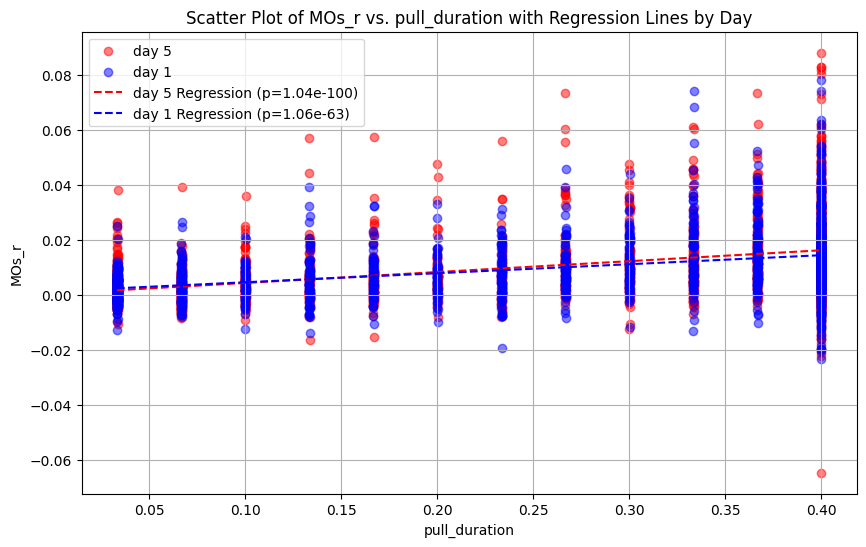

In [ ]:
import statsmodels.api as sm

region = 'MOs_r'

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Get unique values of 'day'
days = cleaned_df['day'].unique()

# Define colors for each day
colors = {'day 1': 'blue', 'day 5': 'red'}

# Plot data for each day
for day in days:
    df_day = cleaned_df[cleaned_df['day'] == day]
    plt.scatter(df_day['pull_duration'], df_day[region], label=day, color=colors[day], alpha=0.5)

# Fit a linear regression model for each day and plot the regression line
for day in days:
    df_day = cleaned_df[cleaned_df['day'] == day].copy()
    X = df_day['pull_duration']
    y = df_day[region]
    X = sm.add_constant(X)  # Add an intercept term to the model
    model = sm.OLS(y, X).fit()
    # Get the p-value for pull_duration
    p_value = model.pvalues['pull_duration']
    # Plot the regression line and include the p-value in the label
    line_x = np.linspace(df_day['pull_duration'].min(), df_day['pull_duration'].max(), 100)
    line_y = model.predict(sm.add_constant(line_x))
    plt.plot(line_x, line_y, color=colors[day], linestyle='--', label=f'{day} Regression (p={p_value:.2e})')


plt.xlabel('pull_duration')
plt.ylabel(region)
plt.title(f'Scatter Plot of {region} vs. pull_duration with Regression Lines by Day')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Fit the mixed linear model with random effects for both mouse_id and trial_number
lme_model_trial3 = smf.mixedlm(
    't_pull_final ~ C(day) + ' + ' + '.join(brain_region_cols),
    data=cleaned_df,
    groups=cleaned_df['mouse_id'],
    vc_formula={'trial': '0 + C(trial_number)'} # Reference trial_number directly
).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM Dependent Variable: t_pull_final
No. Observations:  3689    Method:             REML        
No. Groups:        25      Scale:              0.0107      
Min. group size:   33      Log-Likelihood:     3165.7835   
Max. group size:   243     Converged:          Yes         
Mean group size:   147.6                                   
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
Intercept        0.091    0.003 27.466 0.000   0.084  0.097
C(day)[T.day 5]  0.114    0.004 31.568 0.000   0.107  0.121
AUDp_l          -8.137    1.496 -5.438 0.000 -11.070 -5.204
AUDs_l           9.353    1.767  5.294 0.000   5.890 12.816
MOp_l            2.788    1.048  2.660 0.008   0.734  4.842
MOs_l            0.660    0.996  0.662 0.508  -1.292  2.612
OB_l            -0.216    0.639 -0.338 0.736  -1.469  1.037
RSPagl_l        -7.519    1.425 -5.278 0.000 -10.311 -4.727
RSPd_l           8.214    0.930  8.835 0.000   6.392 10.036
SSp_bfd_l        1.871    0.909  2.057 0.040   0.088  3.653
SSp_ll_l         0.191    0.718  0.265 0.791  -1.217  1.599
SSp_m_l          1.372    0.720  1.905 0.057  -0.040  2.784
SSp_n_l          1.152    0.687  1.677 0.094  -0.194  2.499
SSp_tr_l        -0.949    1.026 -0.925 0.355  -2.960  1.062
SSp_ul_l        -1.739    0.765 -2.275 0.023  -3.238 -0.241
SSp_un_l        -2.835    0.910 -3.117 0.002  -4.618 -1.052
SSs_l           -7.168    1.403 -5.108 0.000  -9.918 -4.418
VISa_l           2.183    1.314  1.661 0.097  -0.393  4.759
VISal_l         -3.091    1.192 -2.593 0.010  -5.427 -0.755
VISam_l         -0.632    1.473 -0.429 0.668  -3.519  2.256
VISl_l          -0.964    0.995 -0.968 0.333  -2.915  0.987
VISp_l          -0.663    0.763 -0.870 0.385  -2.159  0.832
VISpm_l          3.275    0.940  3.486 0.000   1.434  5.117
VISrl_l          0.123    0.908  0.136 0.892  -1.656  1.902
AUDp_r          -0.232    1.461 -0.159 0.874  -3.097  2.632
AUDs_r          -0.212    1.726 -0.123 0.902  -3.595  3.170
MOp_r            6.532    1.023  6.386 0.000   4.528  8.537
MOs_r           -4.573    0.936 -4.885 0.000  -6.407 -2.738
OB_r             1.884    0.683  2.760 0.006   0.546  3.222
RSPagl_r        -1.443    1.313 -1.099 0.272  -4.017  1.131
RSPd_r          -6.696    0.831 -8.054 0.000  -8.325 -5.066
SSp_bfd_r        2.293    0.925  2.480 0.013   0.480  4.105
SSp_ll_r        -2.511    0.689 -3.647 0.000  -3.861 -1.161
SSp_m_r         -2.114    0.690 -3.065 0.002  -3.465 -0.762
SSp_n_r          0.863    0.623  1.385 0.166  -0.358  2.084
SSp_tr_r         1.141    1.034  1.104 0.269  -0.884  3.167
SSp_ul_r         0.312    0.744  0.420 0.674  -1.145  1.770
SSp_un_r        -2.956    0.888 -3.327 0.001  -4.697 -1.214
SSs_r            1.298    1.352  0.960 0.337  -1.352  3.947
VISa_r           1.036    1.262  0.820 0.412  -1.438  3.509
VISal_r          0.514    1.026  0.501 0.616  -1.496  2.524
VISam_r          2.759    1.286  2.146 0.032   0.239  5.279
VISl_r          -1.421    1.064 -1.335 0.182  -3.506  0.664
VISp_r          -0.980    0.761 -1.289 0.197  -2.471  0.510
VISpm_r          2.112    0.869  2.430 0.015   0.409  3.814
VISrl_r         -1.064    0.821 -1.295 0.195  -2.674  0.546
trial Var        0.000    0.007                            
===========================================================

"""

In [ ]:
display(lme_model_trial3.summary().tables[1].sort_values(by='P>|z|', ascending=True))

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
trial Var,0.000,0.007,,,,
SSp_ll_r,-2.511,0.689,-3.647,0.000,-3.861,-1.161
RSPd_r,-6.696,0.831,-8.054,0.000,-8.325,-5.066
MOs_r,-4.573,0.936,-4.885,0.000,-6.407,-2.738
MOp_r,6.532,1.023,6.386,0.000,4.528,8.537
VISpm_l,3.275,0.940,3.486,0.000,1.434,5.117
SSs_l,-7.168,1.403,-5.108,0.000,-9.918,-4.418
RSPd_l,8.214,0.930,8.835,0.000,6.392,10.036
Intercept,0.091,0.003,27.466,0.000,0.084,0.097
AUDs_l,9.353,1.767,5.294,0.000,5.890,12.816


In [ ]:
# Get the summary tables
summary_model2 = lme_model_trial2.summary().tables[1]
summary_model3 = lme_model_trial3.summary().tables[1]

# Define a significance level
alpha = 0.05

# Convert 'P>|z|' column to numeric, coercing errors
summary_model2['P>|z|'] = pd.to_numeric(summary_model2['P>|z|'], errors='coerce')
summary_model3['P>|z|'] = pd.to_numeric(summary_model3['P>|z|'], errors='coerce')


# Get significant regions from model_trial2
significant_regions_model2 = summary_model2[summary_model2['P>|z|'] < alpha].index.tolist()

# Get significant regions from model_trial3
significant_regions_model3 = summary_model3[summary_model3['P>|z|'] < alpha].index.tolist()

# Find regions significant in model_trial3 but not in model_trial2
regions_significant_in_3_not_2 = [region for region in significant_regions_model3 if region not in significant_regions_model2]

# Find regions significant in model_trial2 but not in model_trial3
regions_significant_in_2_not_3 = [region for region in significant_regions_model2 if region not in significant_regions_model3]

print("Regions significant in lme_model_trial3 but not in lme_model_trial2:")
print(regions_significant_in_3_not_2)

print("Regions significant in lme_model_trial2 but not in lme_model_trial3:")
print(regions_significant_in_2_not_3)

Regions significant in lme_model_trial3 but not in lme_model_trial2:
['C(day)[T.day 5]', 'MOp_l', 'RSPagl_l', 'SSp_bfd_l', 'SSs_l', 'OB_r', 'SSp_bfd_r', 'SSp_m_r', 'VISam_r', 'VISpm_r']
Regions significant in lme_model_trial2 but not in lme_model_trial3:
['MOs_l', 'SSp_ll_l', 'SSp_m_l', 'SSp_n_l', 'VISl_l', 'VISrl_l', 'SSp_n_r', 'SSp_tr_r', 'SSp_ul_r', 'SSs_r', 'VISa_r', 'VISal_r', 'VISrl_r']


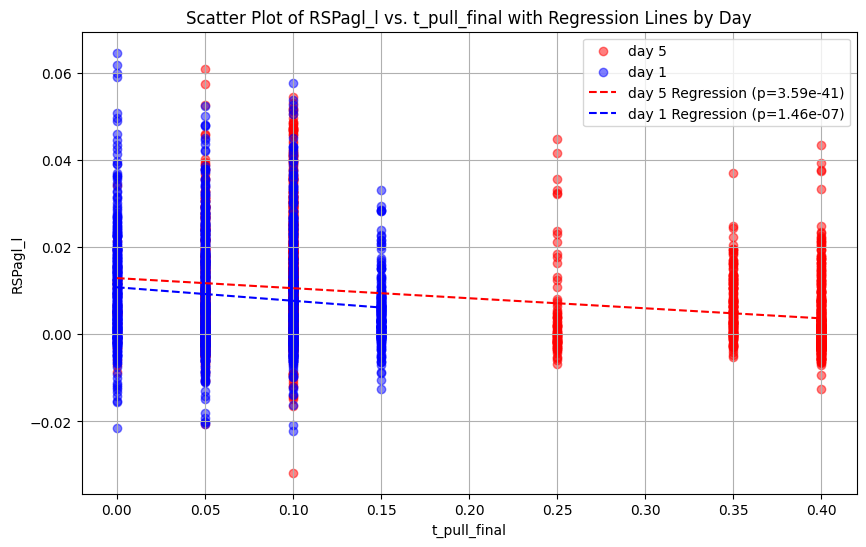

In [ ]:
import statsmodels.api as sm

region = 'RSPagl_l'

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Get unique values of 'day'
days = cleaned_df['day'].unique()

# Define colors for each day
colors = {'day 1': 'blue', 'day 5': 'red'}

# Plot data for each day
for day in days:
    df_day = cleaned_df[cleaned_df['day'] == day]
    plt.scatter(df_day['t_pull_final'], df_day[region], label=day, color=colors[day], alpha=0.5)

# Fit a linear regression model for each day and plot the regression line
for day in days:
    df_day = cleaned_df[cleaned_df['day'] == day].copy()
    X = df_day['t_pull_final']
    y = df_day[region]
    X = sm.add_constant(X)  # Add an intercept term to the model
    model = sm.OLS(y, X).fit()
    # Get the p-value for t_pull_final
    p_value = model.pvalues['t_pull_final']
    # Plot the regression line and include the p-value in the label
    line_x = np.linspace(df_day['t_pull_final'].min(), df_day['t_pull_final'].max(), 100)
    line_y = model.predict(sm.add_constant(line_x))
    plt.plot(line_x, line_y, color=colors[day], linestyle='--', label=f'{day} Regression (p={p_value:.2e})')


plt.xlabel('t_pull_final')
plt.ylabel(region)
plt.title(f'Scatter Plot of {region} vs. t_pull_final with Regression Lines by Day')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Filter data for day 5
day5_df_filtered = combined_auc_dff_df[combined_auc_dff_df['day'] == 'day 5'].copy()

# List of columns to exclude
exclude_cols = ['trial_number', 'mouse_id', 'day', 't_pull_final', 'reaction_time', 'pull_duration']

# Identify brain region columns
brain_region_cols = [col for col in day5_df_filtered.columns if col not in exclude_cols]

# Drop rows with missing values in any of the brain region columns
day5_df_filtered.dropna(subset=brain_region_cols, inplace=True)


In [ ]:
# Assuming day5_df_filtered is available from previous steps
# day5_df_filtered contains data for day 5 with rows having missing brain region AUCs dropped

# List of columns to exclude from averaging
exclude_from_mean = ['mouse_id', 'day'] # Exclude non-numeric columns

# Select columns to average (all columns except those in exclude_from_mean)
columns_to_average = [col for col in day5_df_filtered.columns if col not in exclude_from_mean]

# Average the specified columns by mouse_id
averaged_day5_df = day5_df_filtered.groupby('mouse_id')[columns_to_average].mean()


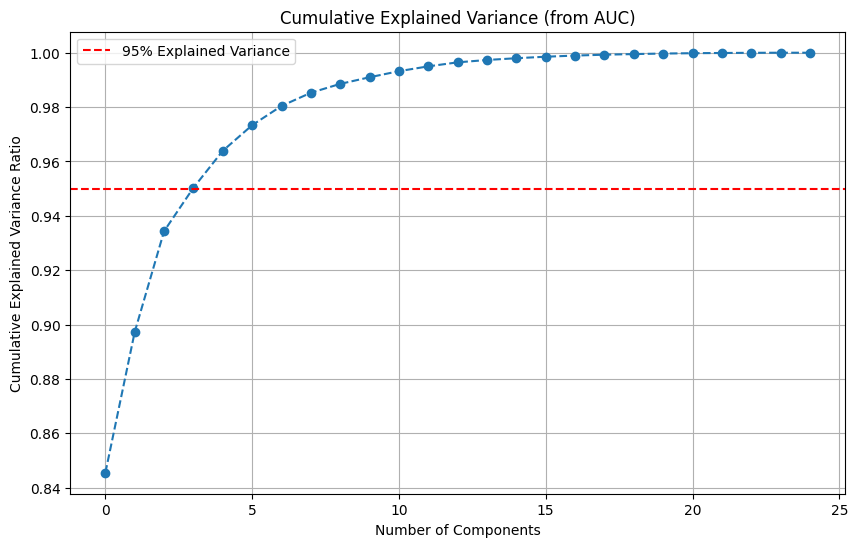

In [ ]:
# Select only the brain region columns for PCA
brain_region_data = averaged_day5_df[brain_region_cols]

scaler = StandardScaler()
scaled_distances = scaler.fit_transform(brain_region_data)

pca = PCA()
principal_components = pca.fit_transform(scaled_distances)

# Analyze explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance (from AUC)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
scaled_brain_region_data = scaler.fit_transform(brain_region_data)

# Apply PCA with 4 components
num_pcs_to_use = 4
pca = PCA(n_components=num_pcs_to_use)
principal_components = pca.fit_transform(scaled_brain_region_data)

# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(principal_components, columns=[f'principal_component_{i+1}' for i in range(num_pcs_to_use)])


In [ ]:
import umap.umap_ as umap

# Apply UMAP to the principal components
reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(pca_df[[f'principal_component_{i+1}' for i in range(num_pcs_to_use)]])

# Create a new DataFrame with the UMAP components
umap_df = pd.DataFrame(umap_embedding, columns=['umap_1', 'umap_2'])

# Add 'mouse_id', 'trial_number', 't_pull_final' and 'RSPagl_l' to the UMAP DataFrame
# Ensure index alignment by using day5_df_filtered
umap_df['t_pull_final'] = averaged_day5_df.reset_index(drop=True)['t_pull_final']
umap_df['RSPagl_l'] = averaged_day5_df.reset_index(drop=True)['RSPagl_l']


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
from sklearn.cluster import KMeans

# Assuming umap_df with 'umap_1' and 'umap_2' is available from previous steps

# Apply K-means clustering to the UMAP components with 2 clusters
kmeans_umap = KMeans(n_clusters=2, random_state=42, n_init=10)
umap_df['umap_cluster'] = kmeans_umap.fit_predict(umap_df[['umap_1', 'umap_2']])


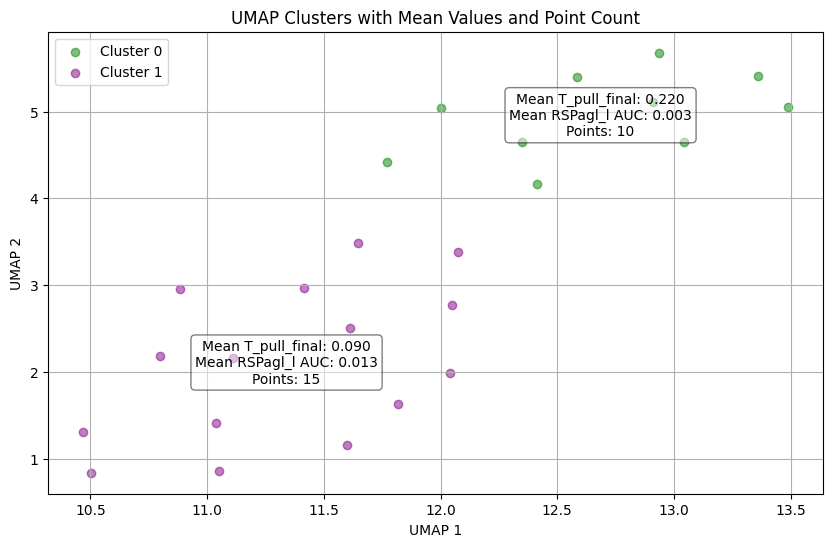

In [ ]:
import matplotlib.pyplot as plt

# Assuming umap_df with 'umap_1', 'umap_2', 'umap_cluster', 't_pull_final', and 'RSPagl_l' is available

# Calculate mean t_pull_final, mean RSPagl_l, and count of points for each cluster
cluster_summary = umap_df.groupby('umap_cluster').agg(
    mean_t_pull_final=('t_pull_final', 'mean'),
    mean_rspagl_auc=('RSPagl_l', 'mean'),
    count=('umap_1', 'count') # Count the number of points in each cluster
).reset_index()


# Visualize the UMAP clusters colored by cluster assignment with annotations
plt.figure(figsize=(10, 6))
colors = ['green', 'purple'] # Define colors for the 2 clusters (can adjust as needed)

for cluster_id in sorted(umap_df['umap_cluster'].unique()):
    cluster_data = umap_df[umap_df['umap_cluster'] == cluster_id]
    plt.scatter(cluster_data['umap_1'], cluster_data['umap_2'], color=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.5)

    # Add annotation for mean t_pull_final, mean RSPagl_l AUC, and count
    mean_t_pull_final = cluster_summary[cluster_summary['umap_cluster'] == cluster_id]['mean_t_pull_final'].iloc[0]
    mean_rspagl_auc = cluster_summary[cluster_summary['umap_cluster'] == cluster_id]['mean_rspagl_auc'].iloc[0]
    count = cluster_summary[cluster_summary['umap_cluster'] == cluster_id]['count'].iloc[0]


    # Find a good position for the annotation (e.g., centroid of the cluster)
    centroid_x = cluster_data['umap_1'].mean()
    centroid_y = cluster_data['umap_2'].mean()

    plt.text(centroid_x, centroid_y, f'Mean T_pull_final: {mean_t_pull_final:.3f}\nMean RSPagl_l AUC: {mean_rspagl_auc:.3f}\nPoints: {count}',
             color='black', ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))


plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Clusters with Mean Values and Point Count')
plt.legend()
plt.grid(True)
plt.show()